In [423]:
# pip install --upgrade spacy

In [424]:
# !python -m spacy download en_core_web_md

In [425]:
# pip install podium-nlp

In [426]:
# pip install hdbscan

In [427]:
# pip install bertopic

In [428]:
# pip install emoji

In [429]:
from tqdm import tqdm
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from bertopic import BERTopic
from podium import Vocab, Field, LabelField
from podium.datasets import TabularDataset
from podium.vectorizers import GloVe
from nltk.sentiment import SentimentIntensityAnalyzer
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
import emoji
import warnings
warnings.filterwarnings("ignore")

In [430]:
# from google.colab import drive
# drive.mount('/content/drive')

In [431]:
# %cd drive/MyDrive/datasets/

# Preprocessing

In [432]:
df = pd.read_csv("train/SemEval2018-T3-train-taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("goldtest_TaskA/SemEval2018-T3_gold_test_taskA_emoji.txt", sep='\t', lineterminator='\n', encoding='utf-8')
df_replace = pd.read_csv("test_TaskA/SemEval2018-T3_input_test_taskA.txt", sep='\t', lineterminator='\n', encoding='utf-8')

In [433]:
df.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_test.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)
df_replace.rename({'Tweet text\r': 'Tweet text'}, inplace=True, axis=1)

In [434]:
df['Tweet text'] = df['Tweet text'].apply(emoji.demojize)

In [435]:
df_test['Tweet text'] = df_test['Tweet text'].apply(emoji.demojize)

## Getting clean text

In [436]:
def preprocess_words(s):
    '''
    Removes tags, emojis, links, smiley faces, hashtag signs, 
    stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][\(\)PDO\/\\\]\[]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_emoji = lambda w: w != ':' and w.startswith(':') and w.endswith(':')
    remove_emoji = lambda w: w[:w.index(':')] + w[w.rindex(':')+1:] if ':' in w and w.index(':') != w.rindex(':') else w
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)
    
    for i, s_i in enumerate(s):
        w_arr = s_i.split()
        w2 = []
        for w in w_arr:
            if is_tag(w) or is_emoji(w) or is_link(w) or is_vertical_line(w):
                continue
            
            elif is_hashtag(w):
                w_tmp = w.replace('#', '')
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            elif is_smiley(w):
                w_tmp = re.sub(smiley_regex, '', w)
                if w_tmp != '':
                    lower_append(w_tmp, w2)
            
            else:
                if w != '':
                    w.replace('#', '')
                    w.replace('|', '')
                    w.replace('_', '')
                    lower_append(w, w2)

        ret_list.append(' '.join(w2))
    return ret_list

def lower_append(w, l):
    l.append(w.lower())

df['clean_text'] = df[['Tweet text']].apply(preprocess_words)
df_test['clean_text'] = df_test[['Tweet text']].apply(preprocess_words)

In [437]:
print(df.shape)
df.head(15)

(3817, 4)


,Tweet index,Label,Tweet text,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,sweet united nations video. just in time for c...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,we are rumored to have talked to erv's agent.....
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,hey there! nice to see you minnesota/nd winter...
3,4,0,3 episodes left I'm dying over here,3 episodes left i'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,i can't breathe! was chosen as the most notabl...
5,6,0,You're never too old for Footie Pajamas. http:...,you're never too old for footie pajamas.
6,7,1,Nothing makes me happier then getting on the h...,nothing makes me happier then getting on the h...
7,8,0,4:30 an opening my first beer now gonna be a l...,4:30 an opening my first beer now gonna be a l...
8,9,0,@Adam_Klug do you think you would support a gu...,do you think you would support a guy who knock...
9,10,0,@samcguigan544 You are not allowed to open tha...,you are not allowed to open that until christm...


In [438]:
def simple_preprocessing(s):
    '''Lowercases, tokenizes, de-accents, removes words shorter than 3 and longer than 14 characters'''
    return [' '.join(simple_preprocess(s_i)) for s_i in s]

df['clean_text'] = df[['clean_text']].apply(simple_preprocessing)
df_test['clean_text'] = df_test[['clean_text']].apply(simple_preprocessing)

In [439]:
print(df.shape)
df.head(15)

(3817, 4)


,Tweet index,Label,Tweet text,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,sweet united nations video just in time for ch...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,we are rumored to have talked to erv agent and...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,hey there nice to see you minnesota nd winter ...
3,4,0,3 episodes left I'm dying over here,episodes left dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,can breathe was chosen as the most notable quo...
5,6,0,You're never too old for Footie Pajamas. http:...,you re never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,nothing makes me happier then getting on the h...
7,8,0,4:30 an opening my first beer now gonna be a l...,an opening my first beer now gonna be long nig...
8,9,0,@Adam_Klug do you think you would support a gu...,do you think you would support guy who knocked...
9,10,0,@samcguigan544 You are not allowed to open tha...,you are not allowed to open that until christm...


In [440]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

df['clean_text'] = df[['clean_text']].apply(remove_tuple_characters)
df_test['clean_text'] = df_test[['clean_text']].apply(remove_tuple_characters)

print(df.shape)
df.head(15)

(3817, 4)


,Tweet index,Label,Tweet text,clean_text
0,1,1,Sweet United Nations video. Just in time for C...,sweet united nations video just in time for ch...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,we are rumored to have talked to erv agent and...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,hey there nice to see you minnesota nd winter ...
3,4,0,3 episodes left I'm dying over here,episodes left dying over here
4,5,1,I can't breathe! was chosen as the most notabl...,can breathe was chosen as the most notable quo...
5,6,0,You're never too old for Footie Pajamas. http:...,you re never too old for footie pajamas
6,7,1,Nothing makes me happier then getting on the h...,nothing makes me happier then getting on the h...
7,8,0,4:30 an opening my first beer now gonna be a l...,an opening my first beer now gonna be long nig...
8,9,0,@Adam_Klug do you think you would support a gu...,do you think you would support guy who knocked...
9,10,0,@samcguigan544 You are not allowed to open tha...,you are not allowed to open that until christm...


In [441]:
nlp = spacy.load("en_core_web_md")

In [442]:
def lemmatize(s):
    '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
    return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

df['lemmas'] = df[['clean_text']].apply(lemmatize)
df_test['lemmas'] = df_test[['clean_text']].apply(lemmatize)

In [443]:
df.head(15)

,Tweet index,Label,Tweet text,clean_text,lemmas
0,1,1,Sweet United Nations video. Just in time for C...,sweet united nations video just in time for ch...,"[sweet, united, nations, video, time, christma..."
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,we are rumored to have talked to erv agent and...,"[rumor, talk, erv, agent, angel, ask, ed, esco..."
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,hey there nice to see you minnesota nd winter ...,"[hey, nice, minnesota, nd, winter, weather]"
3,4,0,3 episodes left I'm dying over here,episodes left dying over here,"[episode, leave, die]"
4,5,1,I can't breathe! was chosen as the most notabl...,can breathe was chosen as the most notable quo...,"[breathe, choose, notable, quote, year, annual..."
5,6,0,You're never too old for Footie Pajamas. http:...,you re never too old for footie pajamas,"[old, footie, pajama]"
6,7,1,Nothing makes me happier then getting on the h...,nothing makes me happier then getting on the h...,"[happy, highway, break, light, light, like, ch..."
7,8,0,4:30 an opening my first beer now gonna be a l...,an opening my first beer now gonna be long nig...,"[opening, beer, long, night, day]"
8,9,0,@Adam_Klug do you think you would support a gu...,do you think you would support guy who knocked...,"[think, support, guy, knock, daughter, rice, d..."
9,10,0,@samcguigan544 You are not allowed to open tha...,you are not allowed to open that until christm...,"[allow, open, christmas, day]"


In [444]:
def word_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if not x.startswith(("@", "#", "http"))]
    return len(newlist)

def char_counter(s):
    s_new = deepcopy(s)
    s_new = s_new.replace(' ', '')
    return len(s_new)

def tag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("@")]
    return len(newlist)

def hashtag_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith("#")]
    return len(newlist)

def has_emoji(s):
    ## potreban upgrade, ne pronalazi sve emoji-e
    splitted = s.split()
    newlist = [x for x in splitted if x != ":" and x.startswith(":") and x.endswith(":")]
    return len(newlist)

### dodani featuresi ###
def link_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if x.startswith(('http:', 'https:'))]
    return len(newlist)

def smiley_counter(s):
    splitted = s.split()
    newlist = [x for x in splitted if re.match(r'([\:\;\=][\(\)PDO\/\\\]\[]+)+', x)]
    return len(newlist)

def mark_counter(s):
    return (s.count('!') + s.count('?') + s.count('...'))


In [445]:
df['word_count'] = df['clean_text'].apply(word_counter)
df['char_count'] = df['clean_text'].apply(char_counter)
df['tag_count'] = df['Tweet text'].apply(tag_counter)
df['hashtag_count'] = df['Tweet text'].apply(hashtag_counter)
df['link_count'] = df['Tweet text'].apply(link_counter)
df['smiley_count'] = df['Tweet text'].apply(smiley_counter)
df['mark_count'] = df['Tweet text'].apply(mark_counter)
df['has_emoji'] = df['Tweet text'].apply(has_emoji)

In [446]:
df_test['word_count'] = df_test['clean_text'].apply(word_counter)
df_test['char_count'] = df_test['clean_text'].apply(char_counter)
df_test['tag_count'] = df_test['Tweet text'].apply(tag_counter)
df_test['hashtag_count'] = df_test['Tweet text'].apply(hashtag_counter)
df_test['link_count'] = df_test['Tweet text'].apply(link_counter)
df_test['smiley_count'] = df_test['Tweet text'].apply(smiley_counter)
df_test['mark_count'] = df_test['Tweet text'].apply(mark_counter)
df_test['has_emoji'] = df_test['Tweet text'].apply(has_emoji)

In [447]:
df.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,smiley_count,mark_count,has_emoji
0,1,1,Sweet United Nations video. Just in time for C...,sweet united nations video just in time for ch...,"[sweet, united, nations, video, time, christma...",11,62,0,2,1,0,0,0
1,2,1,@mrdahl87 We are rumored to have talked to Erv...,we are rumored to have talked to erv agent and...,"[rumor, talk, erv, agent, angel, ask, ed, esco...",19,82,1,0,0,1,2,0
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...,hey there nice to see you minnesota nd winter ...,"[hey, nice, minnesota, nd, winter, weather]",10,44,0,0,0,0,1,0
3,4,0,3 episodes left I'm dying over here,episodes left dying over here,"[episode, leave, die]",5,25,0,0,0,0,0,0
4,5,1,I can't breathe! was chosen as the most notabl...,can breathe was chosen as the most notable quo...,"[breathe, choose, notable, quote, year, annual...",21,96,0,0,0,0,1,0


In [448]:
df_train = df.sample(frac=0.7)
df_validation = df.drop(df_train.index)

In [449]:
df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,smiley_count,mark_count,has_emoji
3178,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,0,0,0
3376,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,0,0,0
2965,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,0,2,0
1483,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,0,0,0
2789,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,0,0,0


In [450]:
def new_df_with_all_features(df1, df2):
    cols_to_add = list(set(df2.columns.tolist()) - set(df1.columns.tolist()))
    if 'Tweet index' in cols_to_add:
        cols_to_add.remove('Tweet index')
    new_df = pd.concat((df1.copy(), df2[cols_to_add]), axis=1)
    return new_df

In [451]:
def join_docs(s):
    '''Joins the strings inside the inner list of a nested list'''
    return ' '.join(s)

df_train['topic_text'] = df_train['lemmas'].apply(join_docs)
df_validation['topic_text'] = df_validation['lemmas'].apply(join_docs)
df_test['topic_text'] = df_test['lemmas'].apply(join_docs)

In [452]:
df_train.shape

(2672, 14)

In [453]:
df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,smiley_count,mark_count,has_emoji,topic_text
3178,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,0,0,0,today fabulous day work ugh
3376,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,0,0,0,people change
2965,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,0,2,0,retweet tweet important issue need resolve
1483,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,0,0,0,love kid wake early christmas
2789,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,0,0,0,sure day lol


## Topic modeling baselines

In [454]:
count_vectorizer = CountVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=20,
    max_df=0.5,
)

tweet_text_count_train = count_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_count_validation = count_vectorizer.transform(df_validation['topic_text'])
tweet_text_count_test = count_vectorizer.transform(df_test['topic_text'])

tweet_text_tfidf_train = tfidf_vectorizer.fit_transform(df_train['topic_text'])
tweet_text_tfidf_validation = tfidf_vectorizer.transform(df_validation['topic_text'])
tweet_text_tfidf_test = tfidf_vectorizer.transform(df_test['topic_text'])

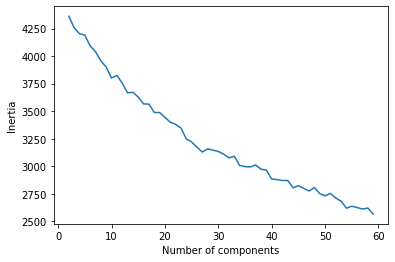

In [455]:
inertia = []
range_ = list(range(2, 60))
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_count_train)
    inertia.append(model.inertia_)
    
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [456]:
model = KMeans(17)
model.fit(tweet_text_count_train)

kmeans_count_labels_train = model.predict(tweet_text_count_train)
kmeans_count_labels_validation = model.predict(tweet_text_count_validation)
kmeans_count_labels_test = model.predict(tweet_text_count_test)

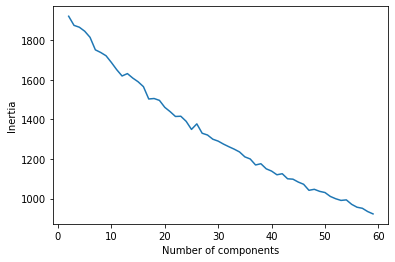

In [457]:
inertia = []
for i in range_:
    model = KMeans(i)
    model.fit(tweet_text_tfidf_train)
    inertia.append(model.inertia_)
plt.plot(range_, inertia)
plt.xlabel('Number of components')
plt.ylabel('Inertia')
plt.show()

In [458]:
model = KMeans(22)
model.fit(tweet_text_tfidf_train)

kmeans_tfidf_labels_train = model.predict(tweet_text_tfidf_train)
kmeans_tfidf_labels_validation = model.predict(tweet_text_tfidf_validation)
kmeans_tfidf_labels_test = model.predict(tweet_text_tfidf_test)

In [459]:
df_train.reset_index(drop=True, inplace=True)
df_validation.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

### BERTopic

In [460]:
topic_model = BERTopic(min_topic_size=40)
topics, probs = topic_model.fit_transform(df_train['topic_text'])

pred_train = topic_model.transform(df_train['topic_text'])
pred_validation = topic_model.transform(df_validation['topic_text'])
pred_test = topic_model.transform(df_test['topic_text'])

In [461]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1328,-1_love_like_work_day
1,0,344,0_pay_co_money_police
2,1,149,1_game_win_good_team
3,2,127,2_know_think_don_funny
4,3,98,3_twitter_tweet_follower_people
5,4,93,4_school_test_study_teacher
6,5,92,5_christmas_gift_holiday_shopping
7,6,86,6_day_today_start_great
8,7,86,7_sleep_wake_hour_love
9,8,75,8_wear_sock_look_invoice


In [462]:
# df_train_bertopic = df_train.copy()
# df_validation_bertopic = df_validation.copy()
# df_test_bertopic = df_test.copy()

In [463]:
df_train['topic'] = pred_train[0]
df_validation['topic'] = pred_validation[0]
df_test['topic'] = pred_test[0]

In [464]:
df_train_bertopic.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,smiley_count,mark_count,has_emoji,topic_text,topic
0,51,1,It will be impossible for me to be late if I s...,it will be impossible for me to be late if sta...,"[impossible, late, start, dress, right, stud, ...",19,76,0,3,0,0,0,0,impossible late start dress right stud univers...,11
1,1267,0,@TedSkibinski @RedState @PamelaJaneVP Maybe th...,maybe they are going to jump in and land on so...,"[maybe, jump, land, technically, ground]",17,72,3,0,0,1,0,0,maybe jump land technically ground,-1
2,815,1,"Well that's my Becky in London with her nan, a...",well that my becky in london with her nan an t...,"[becky, london, nan, big, girl, dan, start, ne...",21,77,0,1,0,0,0,0,becky london nan big girl dan start new job to...,-1
3,219,1,Last day in Naples with my Emma girl! :palm_tr...,last day in naples with my emma girl palm_tree...,"[day, naples, emma, girl, palm_tree, wksandcou...",10,52,0,1,1,0,2,0,day naples emma girl palm_tree wksandcounting,-1
4,3462,1,D-1 test first day :victory_hand::victory_hand...,test first day read book งวย doing home work,"[test, day, read, book, งวย, home, work]",9,36,0,6,0,0,0,1,test day read book งวย home work,11


## Embedding

In [465]:
tweet_embedding_train = df_train[['topic_text', 'Label']]
tweet_embedding_validation = df_validation[['topic_text', 'Label']]
tweet_embedding_test = df_test[['topic_text', 'Label']]

In [466]:
tweet_embedding_train.reset_index(drop=True, inplace=True)
tweet_embedding_validation.reset_index(drop=True, inplace=True)
tweet_embedding_test.reset_index(drop=True, inplace=True)

In [467]:
max_vocab_size = 10_000
vocab = Vocab(max_size=max_vocab_size, min_freq=20)

TWEET = Field('text', numericalizer=vocab)
LABEL = LabelField('Label')

fields = [TWEET, LABEL]

train = TabularDataset.from_pandas(df_train[['topic_text', 'Label']], fields)
validation = TabularDataset.from_pandas(df_validation[['topic_text', 'Label']], fields)
test = TabularDataset.from_pandas(df_test[['topic_text', 'Label']], fields)
train.finalize_fields()

glove = GloVe()
embeddings = glove.load_vocab(vocab)

train_batch = train.batch(add_padding=True)
validation_batch = validation.batch(add_padding=True)
test_batch = test.batch(add_padding=True)

In [468]:
train_batch['text'].astype(int)[0:5]

array([[13,  0,  3,  7,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1],
       [ 8, 66,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1],
       [ 0, 53,  0,  0, 24,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1],
       [ 2, 70, 54,  0, 15,  1,  1,  1,  1,  1,  

In [469]:
tweet_train = embeddings[train_batch['text'].astype(int)]
tweet_validation = embeddings[validation_batch['text'].astype(int)]
tweet_test = embeddings[test_batch['text'].astype(int)]

# Mean
tweet_train_mean = tweet_train.mean(axis=1)
tweet_validation_mean = tweet_validation.mean(axis=1)
tweet_test_mean = tweet_test.mean(axis=1)

In [470]:
embeddings_train_mean_df = pd.DataFrame(tweet_train_mean)
df_train = pd.merge(df_train, embeddings_train_mean_df, left_index=True, right_index=True)

embeddings_validation_mean_df = pd.DataFrame(tweet_validation_mean)
df_validation = pd.merge(df_validation, embeddings_validation_mean_df, left_index=True, right_index=True)

embeddings_test_mean_df = pd.DataFrame(tweet_test_mean)
df_test = pd.merge(df_test, embeddings_test_mean_df, left_index=True, right_index=True)

In [471]:
df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,...,290,291,292,293,294,295,296,297,298,299
0,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,...,1.165566,0.734124,-0.808590,0.837796,-1.236791,0.922806,-0.615856,1.612640,-0.641104,-0.931580
1,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,...,1.179250,0.727799,-0.859068,0.824959,-1.313368,0.934171,-0.608162,1.692765,-0.684620,-1.054756
2,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,...,1.188951,0.759036,-0.768862,0.865132,-1.193870,0.909239,-0.662142,1.605691,-0.613792,-0.839799
3,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,...,1.151240,0.719863,-0.823415,0.810708,-1.251043,0.900487,-0.590320,1.622622,-0.640356,-0.968129
4,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,...,1.166881,0.724177,-0.848193,0.805808,-1.297213,0.899430,-0.585503,1.660241,-0.682326,-1.037417


In [472]:
## Features
## Broj neg rijeci
## Broj poz rijeci
## Omjer
## Udaljenost izmedu poz i neg rijeci

In [473]:
import nltk
nltk.download('vader_lexicon') # if error run this

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [474]:
def pos_neg_words(df, limit):
    sid = SentimentIntensityAnalyzer()

    neg_words = []
    neg_word_count = []
    pos_words = []
    pos_word_count = []
    for index, row in df.iterrows():
        lemmas = []
        if len(row['topic_text']) > 0:
            doc = nlp(row['topic_text'])
            for token in doc:
                lemmas.append(token.lemma_)

            current_pos = []
            current_neut = []
            current_neg = []
            for word in lemmas:
                if (sid.polarity_scores(word)['compound']) >= limit:
                    current_pos.append(word)
                elif (sid.polarity_scores(word)['compound']) <= -limit:
                    current_neg.append(word)
                else:
                    current_neut.append(word)

            neg_words.append(deepcopy(current_neg))
            neg_word_count.append(deepcopy(len(current_neg)))
            pos_words.append(deepcopy(current_pos))
            pos_word_count.append(deepcopy(len(current_pos)))
        else:
            neg_words.append([])
            neg_word_count.append(0)
            pos_words.append([])
            pos_word_count.append(0)
    return neg_words, neg_word_count, pos_words, pos_word_count

In [475]:
neg_words_train, neg_word_count_train, pos_words_train, pos_word_count_train = pos_neg_words(df_train, 0.2)
neg_words_val, neg_word_count_val, pos_words_val, pos_word_count_val = pos_neg_words(df_validation, 0.2)
neg_words_test, neg_word_count_test, pos_words_test, pos_word_count_test = pos_neg_words(df_test, 0.2)

In [476]:
df_train['neg_word_count'] = neg_word_count_train
df_train['pos_word'] = pos_words_train
df_train['pos_word_count'] = pos_word_count_train
df_train['neg_word'] = neg_words_train

df_validation['neg_word_count'] = neg_word_count_val
df_validation['pos_word'] = pos_words_val
df_validation['pos_word_count'] = pos_word_count_val
df_validation['neg_word'] = neg_words_val

df_test['neg_word_count'] = neg_word_count_test
df_test['pos_word'] = pos_words_test
df_test['pos_word_count'] = pos_word_count_test
df_test['neg_word'] = neg_words_test

df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,...,294,295,296,297,298,299,neg_word_count,pos_word,pos_word_count,neg_word
0,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,...,-1.236791,0.922806,-0.615856,1.612640,-0.641104,-0.931580,1,[fabulous],1,[ugh]
1,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,...,-1.313368,0.934171,-0.608162,1.692765,-0.684620,-1.054756,0,[],0,[]
2,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,...,-1.193870,0.909239,-0.662142,1.605691,-0.613792,-0.839799,0,"[important, resolve]",2,[]
3,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,...,-1.251043,0.900487,-0.590320,1.622622,-0.640356,-0.968129,0,[love],1,[]
4,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,...,-1.297213,0.899430,-0.585503,1.660241,-0.682326,-1.037417,0,"[sure, lol]",2,[]


In [477]:
topic_dummies = []
for i in topic_model.get_topic_info()['Topic'].values:
    topic_dummies.append(f'{i}_topic')
    
topic_dummies

['-1_topic',
 '0_topic',
 '1_topic',
 '2_topic',
 '3_topic',
 '4_topic',
 '5_topic',
 '6_topic',
 '7_topic',
 '8_topic',
 '9_topic',
 '10_topic',
 '11_topic',
 '12_topic']

In [478]:
df_train[topic_dummies] = pd.get_dummies(df_train['topic'])
df_validation[topic_dummies] = pd.get_dummies(df_validation['topic'])
df_test[topic_dummies] = pd.get_dummies(df_test['topic'])
df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,...,3_topic,4_topic,5_topic,6_topic,7_topic,8_topic,9_topic,10_topic,11_topic,12_topic
0,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,...,0,0,0,1,0,0,0,0,0,0
1,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [479]:
X_ = df_train[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
               '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
y_ = df_train['Label']
clf = LogisticRegression(random_state=0, solver='liblinear').fit(X_, y_)

print('Train score')
print(clf.score(X_, y_))

X_val = df_validation[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
               '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
y_val = df_validation['Label']

print('Validation score')
print(clf.score(X_val, y_val))

X_val = df_test[['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', 'mark_count', 'has_emoji', 'neg_word_count', 'pos_word_count',
               '-1_topic', '0_topic', '1_topic', '2_topic', '3_topic', '4_topic', '5_topic', '6_topic', '7_topic']]
y_val = df_test['Label']
print('Test score')
print(clf.score(X_val, y_val))

Train score
0.6437125748502994
Validation score
0.6148471615720524
Test score
0.6033163265306123


In [480]:
## Pos and neg words within 4 words
df_train[['clean_text', 'pos_word', 'pos_word_count', 'neg_word', 'neg_word_count']].iloc[25]

clean_text        sweet united nations video just in time for ch...
pos_word                                            [sweet, united]
pos_word_count                                                    2
neg_word                                                         []
neg_word_count                                                    0
Name: 25, dtype: object

In [481]:
def pos_neg_within_n(df, n=4):

    ret_array = []

    for index, row in df.iterrows():
        if row['pos_word_count'] > 0 and row['neg_word_count'] > 0:
            doc = nlp(row['clean_text'])
            lemmas = []
            for token in doc:
                lemmas.append(token.lemma_)

            pos_indexes = np.array([])
            for word in row['pos_word']:
                pos_indexes = np.append(pos_indexes, np.where(np.array(lemmas) == word))
            neg_indexes = np.array([])
            for word in row['neg_word']:
                neg_indexes = np.append(neg_indexes, np.where(np.array(lemmas) == word))

            bool_val = 0
            for idx in pos_indexes:
                if (abs(neg_indexes-idx) < n).any():
                    bool_val = 1
            ret_array.append(deepcopy(bool_val))
        else:
            ret_array.append(0)
    return ret_array

In [482]:
within_5_train = pos_neg_within_n(df_train, n=5)
within_5_val = pos_neg_within_n(df_validation, n=5)

In [483]:
df_train['pos_neg_within_5'] = within_5_train
df_validation['pos_neg_within_5'] = within_5_val

df_train.head()

,Tweet index,Label,Tweet text,clean_text,lemmas,word_count,char_count,tag_count,hashtag_count,link_count,...,4_topic,5_topic,6_topic,7_topic,8_topic,9_topic,10_topic,11_topic,12_topic,pos_neg_within_5
0,3193,1,Today is a fabulous day #Work #Ugggh,today is fabulous day work ugh,"[today, fabulous, day, work, ugh]",6,25,0,2,0,...,0,0,1,0,0,0,0,0,0,1
1,3391,0,people never change and that's that,people never change and that that,"[people, change]",6,28,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2969,1,Why can't I (You) retweet my (your) own tweets...,why can you retweet my your own tweets this is...,"[retweet, tweet, important, issue, need, resolve]",18,74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1484,1,Love that I still have kids that still wake up...,love that still have kids that still wake up e...,"[love, kid, wake, early, christmas]",12,52,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2793,1,@TheWarRoom_Tom I am sure this has made your d...,am sure this has made your day lol,"[sure, day, lol]",8,27,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [484]:
X_ = df_train[[ 'pos_neg_within_5']]
y_ = df_train['Label']

clf = LogisticRegression().fit(X_, y_)
print('Train score')
print(clf.score(X_, y_))

X_val = df_validation[[ 'pos_neg_within_5']]
y_val = df_validation['Label']

print('Validation score')
print(clf.score(X_val, y_val))

Train score
0.5082335329341318
Validation score
0.5213973799126638


## Baseline classifiers

In [502]:
baseline_features = ['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', \
                     'link_count', 'smiley_count', 'mark_count', 'has_emoji']

y_train = df_train['Label']
x_train = df_train[baseline_features]

y_validation = df_validation['Label']
x_validation = df_validation[baseline_features]

y_test = df_test['Label']
x_test = df_test[baseline_features]

In [505]:
x_train.head()

,word_count,char_count,tag_count,hashtag_count,link_count,smiley_count,link_count,smiley_count,mark_count,has_emoji
0,6,25,0,2,0,0,0,0,0,0
1,6,28,0,0,0,0,0,0,0,0
2,18,74,0,0,0,0,0,0,2,0
3,12,52,0,1,0,0,0,0,0,0
4,8,27,1,0,0,0,0,0,0,0


In [521]:
def model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    print('-------------------------- TRAIN --------------------------')
    print(classification_report(y_train, y_train_pred, digits=3), 2*'\n')
    
    y_validation_pred = model.predict(x_validation)
    print('----------------------- VALIDATION ------------------------')
    print(classification_report(y_validation, y_validation_pred, digits=3), 2*'\n')
    
    y_test_pred = model.predict(x_test)
    print('------------------------- TEST ---------------------------')
    print(classification_report(y_test, y_test_pred, digits=3), 2*'\n')

In [507]:
model = LogisticRegression()
baseline_model_fit_evaluate(model, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.648     0.533     0.585      1336
           1      0.603     0.710     0.652      1336

    accuracy                          0.622      2672
   macro avg      0.626     0.622     0.619      2672
weighted avg      0.626     0.622     0.619      2672
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.625     0.521     0.568       580
           1      0.580     0.680     0.626       565

    accuracy                          0.599      1145
   macro avg      0.603     0.600     0.597      1145
weighted avg      0.603     0.599     0.597      1145
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.699     0.579     0.634       473
           1      0.492     0.621     0.549       31

## Baseline classifiers for the first 5 topics

In [508]:
baseline_features = ['word_count', 'char_count', 'tag_count', 'hashtag_count', 'link_count', 'smiley_count', \
                     'link_count', 'smiley_count', 'mark_count', 'has_emoji']


def get_train_validation_and_test_for_topic(topic_num, df_train, df_validation, df_test):
    df_train_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_validation_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    df_test_topic = df_train[df_train[f'{topic_num}_topic'] == 1]
    
    y_train = df_train_topic['Label']
    x_train = df_train_topic[baseline_features]

    y_validation = df_validation_topic['Label']
    x_validation = df_validation_topic[baseline_features]

    y_test = df_test_topic['Label']
    x_test = df_test_topic[baseline_features]

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [509]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(-1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.649     0.593     0.620       680
           1      0.608     0.664     0.635       648

    accuracy                          0.627      1328
   macro avg      0.629     0.628     0.627      1328
weighted avg      0.629     0.627     0.627      1328
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.649     0.593     0.620       680
           1      0.608     0.664     0.635       648

    accuracy                          0.627      1328
   macro avg      0.629     0.628     0.627      1328
weighted avg      0.629     0.627     0.627      1328
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.649     0.593     0.620       680
           1      0.608     0.664     0.635       64

In [510]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(0, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.635     0.642     0.639       190
           1      0.553     0.545     0.549       154

    accuracy                          0.599       344
   macro avg      0.594     0.594     0.594       344
weighted avg      0.598     0.599     0.599       344
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.635     0.642     0.639       190
           1      0.553     0.545     0.549       154

    accuracy                          0.599       344
   macro avg      0.594     0.594     0.594       344
weighted avg      0.598     0.599     0.599       344
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.635     0.642     0.639       190
           1      0.553     0.545     0.549       15

In [511]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(1, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.624     0.922     0.744        90
           1      0.562     0.153     0.240        59

    accuracy                          0.617       149
   macro avg      0.593     0.537     0.492       149
weighted avg      0.600     0.617     0.545       149
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.624     0.922     0.744        90
           1      0.562     0.153     0.240        59

    accuracy                          0.617       149
   macro avg      0.593     0.537     0.492       149
weighted avg      0.600     0.617     0.545       149
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.624     0.922     0.744        90
           1      0.562     0.153     0.240        5

In [512]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(2, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.600     0.516     0.555        64
           1      0.569     0.651     0.607        63

    accuracy                          0.583       127
   macro avg      0.585     0.583     0.581       127
weighted avg      0.585     0.583     0.581       127
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.600     0.516     0.555        64
           1      0.569     0.651     0.607        63

    accuracy                          0.583       127
   macro avg      0.585     0.583     0.581       127
weighted avg      0.585     0.583     0.581       127
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.600     0.516     0.555        64
           1      0.569     0.651     0.607        6

In [513]:
x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_ = \
    get_train_validation_and_test_for_topic(3, df_train, df_validation, df_test)

model = LogisticRegression()
model_fit_evaluate(model, x_train_, y_train_, x_validation_, y_validation_, x_test_, y_test_)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.698     0.685     0.692        54
           1      0.622     0.636     0.629        44

    accuracy                          0.663        98
   macro avg      0.660     0.661     0.660        98
weighted avg      0.664     0.663     0.664        98
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.698     0.685     0.692        54
           1      0.622     0.636     0.629        44

    accuracy                          0.663        98
   macro avg      0.660     0.661     0.660        98
weighted avg      0.664     0.663     0.664        98
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.698     0.685     0.692        54
           1      0.622     0.636     0.629        4

## Grid search

In [519]:
pipeline_lr = Pipeline([
    ('selection', SelectKBest()), 
    ('scaler', StandardScaler()),
    ('pf', PolynomialFeatures()),
    ('lr', LogisticRegression())
])

params = {
    'selection__k': list(range(2, 20, 3)),
    'lr__penalty': ['l1', 'l2', 'elasticnet'], 
    'lr__C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 5],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'pf__degree': list(range(1, 4)), 
}


search = GridSearchCV(pipeline_lr, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6321152297945325
Best score: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'pf__degree': 3, 'selection__k': 8}


In [524]:
pipeline_lr_best = Pipeline([
    ('selection', SelectKBest(k=8)), 
    ('scaler', StandardScaler()),
    ('pf', PolynomialFeatures(degree=3)),
    ('lr', LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))
])

model_fit_evaluate(pipeline_lr_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.640     0.631     0.636      1336
           1      0.636     0.645     0.641      1336

    accuracy                          0.638      2672
   macro avg      0.638     0.638     0.638      2672
weighted avg      0.638     0.638     0.638      2672
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.630     0.586     0.607       580
           1      0.603     0.646     0.624       565

    accuracy                          0.616      1145
   macro avg      0.616     0.616     0.616      1145
weighted avg      0.617     0.616     0.615      1145
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.811     0.609     0.696       473
           1      0.569     0.785     0.659       31

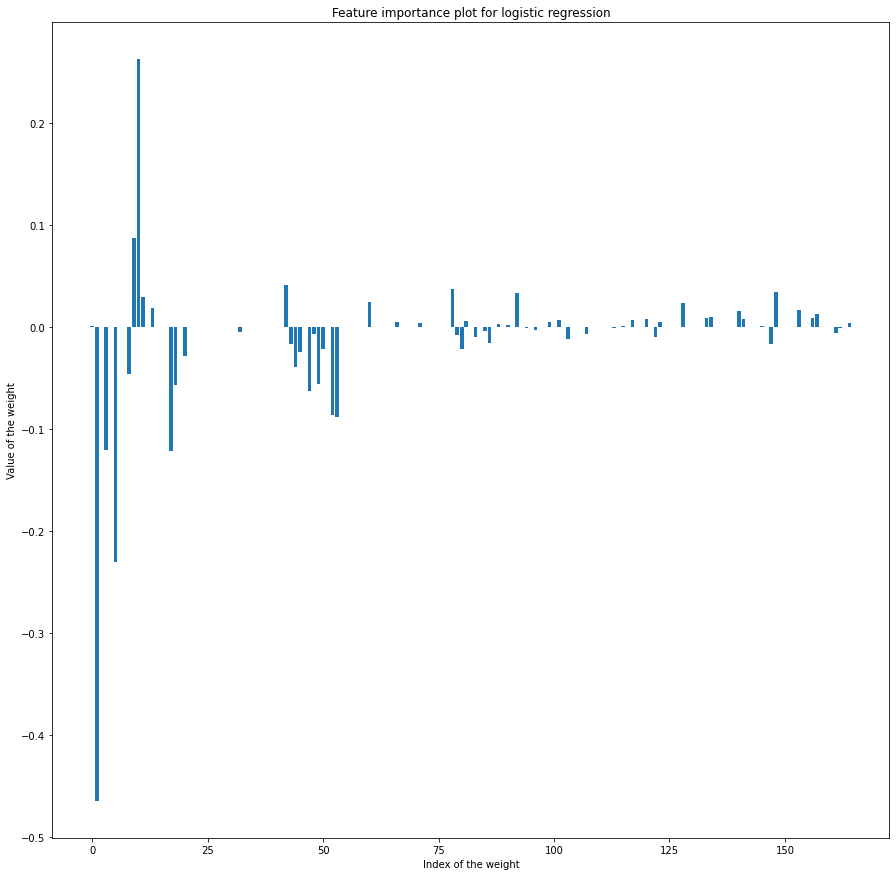

In [550]:
weights = pipeline_lr_best['lr'].coef_.flatten()

plt.figure(figsize=(15, 15))
plt.bar(list(range(len(weights))), weights)
plt.ylabel('Value of the weight')
plt.xlabel('Index of the weight')
plt.title('Feature importance plot for logistic regression')
plt.show()

In [543]:
pipeline_dtc = Pipeline([
    ('selection', SelectKBest()), 
    ('dtc', DecisionTreeClassifier()),
])

params = {
    'selection__k': list(range(2, 20, 3)),
    'dtc__max_features': ['auto', 'sqrt', 'log2'],
    'dtc__ccp_alpha': [0.1, .01, .001],
    'dtc__max_depth' : list(range(2, 10)),
    'dtc__criterion' : ['gini', 'entropy', 'log_loss']
}

search = GridSearchCV(pipeline_dtc, param_grid=params, cv=5)
search.fit(x_train, y_train)

print(f'Best score: {search.best_score_}')
print(f'Best score: {search.best_params_}')

Best score: 0.6347348524624593
Best score: {'dtc__ccp_alpha': 0.001, 'dtc__criterion': 'entropy', 'dtc__max_depth': 5, 'dtc__max_features': 'auto', 'selection__k': 5}


In [545]:
pipeline_dtc_best = Pipeline([
    ('selection', SelectKBest(k=5)), 
    ('dtc', DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=5, max_features='auto')),
])

model_fit_evaluate(pipeline_dtc_best, x_train, y_train, x_validation, y_validation, x_test, y_test)

-------------------------- TRAIN --------------------------
              precision    recall  f1-score   support

           0      0.630     0.653     0.641      1336
           1      0.640     0.617     0.628      1336

    accuracy                          0.635      2672
   macro avg      0.635     0.635     0.635      2672
weighted avg      0.635     0.635     0.635      2672
 


----------------------- VALIDATION ------------------------
              precision    recall  f1-score   support

           0      0.618     0.595     0.606       580
           1      0.600     0.623     0.611       565

    accuracy                          0.609      1145
   macro avg      0.609     0.609     0.609      1145
weighted avg      0.609     0.609     0.609      1145
 


------------------------- TEST ---------------------------
              precision    recall  f1-score   support

           0      0.799     0.615     0.695       473
           1      0.567     0.765     0.651       31

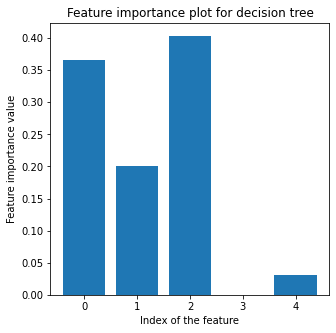

In [551]:
feat_importances = pipeline_dtc_best['dtc'].feature_importances_.flatten()

plt.figure(figsize=(5, 5))
plt.bar(list(range(len(feat_importances))), feat_importances)
plt.ylabel('Feature importance value')
plt.xlabel('Index of the feature')
plt.title('Feature importance plot for decision tree')
plt.show()